# DSCI 100 GROUP 15 Report

### Hyunseok Jung, Jordan Sanders, Ivie Huang, Eden Vasica

## Introduction

The government of Canada provides historical data on weather and climate. Its' hourly weather data report consists of various climate observations such as temperature, humidity, and wind speed, as well as a column classifying the weather type (e.g. "Mostly Cloudy"). We are excited to test our ability to build a classification model for weather types based on climate observations from this dataset. To make our project more enjoyable and personal, we decided to work with historical weather and climate data provided by the 'Vancouver Intl A' weather station, which is not far from UBC. This facility, located in the Vancouver International Airport, is one of the most significant weather stations in Vancouver that collects measurements for weather forecasts and climate studies hourly. Unlike hourly data reports, daily and monthly data reports do not include a weather column making it impossible to build a classification model.

Considering seasonal climate differences and fluctuations, we decided to focus on weather reports from June, to reduce the number of external factors affecting the observations. As we will be handling an hourly data report, we have sufficient observations to build a classification model. In addition, to minimize the influence of global warming on temperature for our classification model, we will use recent data to train our model: June 2022.

## Methods & Results
1. Download all June 2022 hourly data from the government of Canada website, tidy it, and combine it into one dataframe.
2. Split the data into `training_set` and `testing_set`.
3. Randomly sample 500 observations and balance the data using `sample_n` and `step_upsample`
3. Select the predictor variables that results in the highest accuracy in a forward selection process
4. Create a recipe that uses the predictors selected and a model specification with tuning on the number of neighbours using `tune()`. Also Use the `step_scale(all_predictors())` function and the `step_center(all_predictors())` function to scale and center our data.
5. Perform a 5-fold cross-validation on the training set using `vfold_cv` function
6. Create a workflow analysis with our recipe and model specification using `workflow()` function
7. Collect the metrics from the workflow analysis using the `collect_metrics` function.
8. Plot the $k$ vs the accuracy and identify which $k$ the most optimal for our data set for k-nn classification. 
9. Create a new model specification for with the identified best value $k$ using the `nearest_neighbor()` function.
10. Train the classifier with the training data set using the `workflow` function. Instead of using `fit` or `fit_resamples`, we will use the `tune_grid` function to fit the model for each value in a range of parameter values. For the `resamples` argument, we will input the cross-validation model we created earlier.
11. Use our final model to predict on the test dataset `testing_set`
12. Record the accuracy of this prediction, and store this in an object
13. Plot the accuracy of our model on a bar graph for each category of Weather column

In [ ]:
install.packages("tidyverse")
install.packages("repr")
install.packages("tidymodels")
install.packages("GGally")
install.packages("themis")

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(themis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


Initially, as presented in our proposal, we intended to use June 2020 and June 2021 to train our model and use June 2022 data for our testing set. Therefore, although we end up using June 2022 data for our model (which will be described later), our data wrangling and cleaning process includes all of June 2020, 2021, and 2022 data files.

The hourly data report of "Vancouver Intl A" from the government of Canada website can be found at the URL below. The link below will take you to the hourly data report from 2022 June 1st.
https://climate.weather.gc.ca/climate_data/hourly_data_e.html?hlyRange=2013-06-11%7C2022-06-22&dlyRange=2013-06-13%7C2022-06-22&mlyRange=%7C&StationID=51442&Prov=BC&urlExtension=_e.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2022&selRowPerPage=25&Line=2&searchMethod=contains&txtStationName=vancouver+intl&timeframe=1&time=LST&time=LST&Year=2022&Month=6&Day=1#

Since the data report with the Weather column is only available on a 24-hour basis, we had to download 30 individual .csv files for June 2020 and June 2021, respectively, and 19 individual .csv files for June 2022 (June 19th data was the most recent file that was available when we started working on our project) from the government of Canada website. 

We first worked locally to clean and wrangle individual .csv files. Then we combined the tidied data into one data frame. Finally, we then uploaded all of them into our Github repository: https://github.com/hyunseokjg/DSCI100-Group15-Project so that the final data set that will be used in our project is readily available and reproducible.

In our Github repository, you can access raw and tidied data for each day, as well as the Jupiter notebook file that was used to clean, wrangle and combine the data files. For convenience, the codes used for 2022 June data are attached below as example.

In [ ]:
# Reading in 2022 June 1st data
df1 <- read_csv("data/2022_June_1.csv")

# Renaming Column Names
colnames(df1) <- make.names(colnames(df1))
tidy_df1 <- df1 %>%
    select(Temp...C., Rel.Hum...., Wind.Spd..km.h., Visibility..km., Stn.Press..kPa., Weather) %>%
    filter(Weather != "NA") 
tidy_df1 <- rename(tidy_df1,
       Temp = Temp...C., 
       Humid = Rel.Hum...., 
       Wind_Spd = Wind.Spd..km.h.,
       Vis = Visibility..km., 
       Press = Stn.Press..kPa.)

# Mutating weather column as factor
tidy_df1 <- tidy_df1 %>%
    mutate(Weather = as_factor(Weather))

# Saving tidy data
write_csv(tidy_df1, "data/tidy_2022_June_1.csv")

# Reading in all tidy data of June 2022
df1 <- read_csv("tidy_data/tidy_2022_June_1.csv")
df2 <- read_csv("tidy_data/tidy_2022_June_2.csv")
df3 <- read_csv("tidy_data/tidy_2022_June_3.csv")
df4 <- read_csv("tidy_data/tidy_2022_June_4.csv")
df5 <- read_csv("tidy_data/tidy_2022_June_5.csv")
df6 <- read_csv("tidy_data/tidy_2022_June_6.csv")
df7 <- read_csv("tidy_data/tidy_2022_June_7.csv")
df8 <- read_csv("tidy_data/tidy_2022_June_8.csv")
df9 <- read_csv("tidy_data/tidy_2022_June_9.csv")
df10 <- read_csv("tidy_data/tidy_2022_June_10.csv")
df11 <- read_csv("tidy_data/tidy_2022_June_11.csv")
df12 <- read_csv("tidy_data/tidy_2022_June_12.csv")
df13 <- read_csv("tidy_data/tidy_2022_June_13.csv")
df14 <- read_csv("tidy_data/tidy_2022_June_14.csv")
df15 <- read_csv("tidy_data/tidy_2022_June_15.csv")
df16 <- read_csv("tidy_data/tidy_2022_June_16.csv")
df17 <- read_csv("tidy_data/tidy_2022_June_17.csv")
df18 <- read_csv("tidy_data/tidy_2022_June_18.csv")
df19 <- read_csv("tidy_data/tidy_2022_June_19.csv")

# Merging multiple data file into single table
df_final <- bind_rows(df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19)

# Saving the merged table into .csv file
write_csv(df_final, "tidy_data/testing_set.csv")

As mentioned above, since we initially intended to use June 2022 data for our testing set, the name of the combined tidy data of June 2022 is called the testing_set.csv. 

While we were working on our model with our training set (combined file with June 2020 and 2021 data), we encountered a problem where the accuracy estimates for different numbers of neighbors returned 100% accuracy for all values of k. Our initial instinct was to test if this pattern persists even if we reduce the number of observations by randomly sampling 1000 observations from our training set. This time, our accuracy was also very high at around 97% for k = 1 and 2, then gradually decreased as the number of neighbors increased. Such problems were unforeseen errors caused by our data set's characteristics. Our weather data is a time-series data where each observation is indexed in time order. So, the recorded variable in the weather column was bound to the observation made at that particular time.
Consequently, the time-related component of our data had a negative impact on the predictions as we increased the number of neighbors. Furthermore, the KNN classification model we covered in DSCI 100 uses a Euclidian distance metric that cannot measure the distance between multiple time series. This suggests a possible reason that accuracy decreases as we increase the number of neighbors. Thus, we suspected that a large number of observations in our training set, 16890 rows (shown below), were disturbing the accuracy measures. As a result, we decided to sample 500 observations from the most recent 2022 data (testing set) to minimize the effect of both time aspects of our data and the influence of global warming on temperature for our classification model.

In [2]:
weather_training_for_display <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/training_set.csv")
nrow(weather_training_for_display)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



[1] 16890

In [31]:
options(repr.matrix.max.rows = 9)
set.seed(2022) #we need this to make our code reproducible, since sample is a random function

weather_data <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/testing_set.csv")
paste("Table 1.1 - Entire Training Data (Unbalanced, Unfiltered)")
weather_data
paste("Caption - A sample of what our raw training data looks like, before rare weather classifications are filtered out.")

#Let's remove the very rare weather classes for simplicity and so we do not overreppresent them when we balance our data

filtered_weather_data <- weather_data %>%
    filter(Weather != "Heavy Rain", 
           Weather != "Moderate Rain",
           Weather != "Clear",
           Weather != "Moderate Rain,Fog") %>%
    mutate(Weather = as_factor(Weather)) %>%
    sample_n(500)
paste("Table 1.2 - Filtered Training Data (Unbalanced)")
filtered_weather_data
paste("Caption - A sample of the training data after rare weather classifications were removed and 500 observations were randomly sampled.")

#Now we can split our dataset into training and testing sets using the initial_split function so we don't create our model with the same
#data that we will use to test it later on.

weather_split <- initial_split(filtered_weather_data, prop = 0.75, strata = Weather)
weather_train = training(weather_split)
weather_test = testing(weather_split)

Parsed with column specification:
cols(
  Temp = col_double(),
  Humid = col_double(),
  Wind_Spd = col_double(),
  Vis = col_double(),
  Press = col_double(),
  Weather = col_character()
)



[1] "Table 1.1 - Entire Training Data (Unbalanced, Unfiltered)"

Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
12.8,100,4,32.2,101.78,Mostly Cloudy
10.4,100,4,32.2,101.72,Mostly Cloudy
15.3,80,3,48.3,101.72,Mostly Cloudy
16.8,85,19,48.3,101.65,Mostly Cloudy
17.2,84,18,48.3,101.54,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
15.7,81,12,32.2,102.19,Cloudy
17.3,72,9,48.3,102.19,Mostly Cloudy
16.4,69,15,32.2,102.14,Mainly Clear


[1] "Caption - A sample of what our raw training data looks like, before rare weather classifications are filtered out."

[1] "Table 1.2 - Filtered Training Data (Unbalanced)"

Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15.9,81,18,48.3,100.73,Rain Showers
12.0,84,28,32.2,101.89,Mostly Cloudy
15.3,96,21,24.1,100.54,Rain
15.6,77,16,48.3,101.49,Mostly Cloudy
19.0,74,11,48.3,101.18,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
13.1,83,8,32.2,102.08,Mainly Clear
18.6,79,18,48.3,100.48,Mostly Cloudy
18.6,79,18,48.3,100.48,Mostly Cloudy


[1] "Caption - A sample of the training data after rare weather classifications were removed and 500 observations were randomly sampled."

In [33]:
#check to see if proportions of data are close enough to use or if we should scale up some
#of the other weather classifications

number_rows <- nrow(weather_train)

proportions <- weather_train %>%
    group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)
paste("Table 1.3 - Proportions of Training Data (Unbalanced)")
proportions
paste("Caption - The number of observations for each of the remaining weather classes in our dataset, 
and the percentage of the dataset that it makes up.")

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 1.3 - Proportions of Training Data (Unbalanced)"

Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,84,22.28117
Rain Showers,30,7.95756
Rain,103,27.32095
Mainly Clear,47,12.46684


[1] "Caption - The number of observations for each of the remaining weather classes in our dataset, \nand the percentage of the dataset that it makes up."

In [34]:
#now because we can see our classes are unbalanced, we want to balance our classes using step_upsample
ups_recipe <- recipe(Weather ~ ., data = weather_train) %>%
    step_upsample(Weather, over_ratio = 1, skip = FALSE) %>%
    prep()

#now we create our new training data set with balanced classes
upsampled_weather <- bake(ups_recipe, weather_train)

#now we check weather our classes have been properly balanced
paste("Table 1.4 - Proportions of Upscaled Data (Balanced Training Data)")
upsampled_weather %>% group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)
paste("Caption - This table shows us that our use of step_upsample to balance each weather classification was successful.")

[1] "Table 1.4 - Proportions of Upscaled Data (Balanced Training Data)"

`summarise()` ungrouping output (override with `.groups` argument)



Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,113,29.97347
Rain Showers,113,29.97347
Rain,113,29.97347
Mainly Clear,113,29.97347


[1] "Caption - This table shows us that our use of step_upsample to balance each weather classification was successful."

In [6]:
set.seed(2022)

#now we will create the functions we will use many times later in forward selection and our final model. 
weather_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

weather_vfold <- vfold_cv(weather_train, v = 5, strata = Weather)

k_grid <- tibble(neighbors = 1:30)

### Forward Selection - Predictor Variable Selection Process

#### Phase 1: One Variable

In [38]:
set.seed(2022)

# Model 1.1 - Temperature
temp_recipe <- recipe(Weather ~ Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp_fit <- workflow() %>%
    add_recipe(temp_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp_accuracy <- temp_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.1 - Accuracy of Temp")
temp_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors
when forward selection is done with the predictor variable Temperature only.")

[1] "Table 2.1 - Accuracy of Temp"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4696491,5,0.02163649,Model02


[1] "Caption - Highest accuracy and the accompanying number of neighbors\nwhen forward selection is done with the predictor variable Temperature only."

In [40]:
set.seed(2022)

# Model 2.1 - Humidity
humid_recipe <- recipe(Weather ~ Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid_fit <- workflow() %>%
    add_recipe(humid_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid_accuracy <- humid_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.2 - Accuracy of Humid")
humid_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors
when forward selection is done with the predictor variable Humidity only.")

[1] "Table 2.2 - Accuracy of Humid"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,multiclass,0.5016491,5,0.03015338,Model15


[1] "Caption - Highest accuracy and the accompanying number of neighbors\nwhen forward selection is done with the predictor variable Humidity only."

In [41]:
set.seed(2022)

# Model 3.1 - Wind Speed
wind_recipe <- recipe(Weather ~ Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind_fit <- workflow() %>%
    add_recipe(wind_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind_accuracy <- wind_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.3 - Accuracy of Wind_Spd")
wind_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors
when forward selection is done with the predictor variable Wind Speed only.")

[1] "Table 2.3 - Accuracy of Wind_Spd"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,multiclass,0.4112982,5,0.02957338,Model09


[1] "Caption - Highest accuracy and the accompanying number of neighbors\nwhen forward selection is done with the predictor variable Wind Speed only."

In [42]:
set.seed(2022)

# Model 4.1 - Visability
vis_recipe <- recipe(Weather ~ Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis_fit <- workflow() %>%
    add_recipe(vis_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis_accuracy <- vis_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.4 - Accuracy of Vis")
vis_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors
when forward selection is done with the predictor variable Visibility only.")

[1] "Table 2.4 - Accuracy of Vis"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
20,accuracy,multiclass,0.4801754,5,0.008618661,Model20


[1] "Caption - Highest accuracy and the accompanying number of neighbors\nwhen forward selection is done with the predictor variable Visibility only."

In [44]:
set.seed(2022)

# Model 5.1 - Air Pressure
press_recipe <- recipe(Weather ~ Press, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

press_fit <- workflow() %>%
    add_recipe(press_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

press_accuracy <- press_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.5 - Accuracy of Press")
press_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors
when forward selection is done with the predictor variable Air Pressure only.")

[1] "Table 2.5 - Accuracy of Press"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.674,5,0.02835646,Model02


[1] "Caption - Highest accuracy and the accompanying number of neighbors\nwhen forward selection is done with the predictor variable Air Pressure only."

**Findings:** Using air pressure has the highest prediction accuracy so far.

#### Phase 2: Two Predictor Variables

In [47]:
set.seed(2022)

# Model 1.2 - Air Pressure + Temperature
temp2_recipe <- recipe(Weather ~ Press + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp2_fit <- workflow() %>%
    add_recipe(temp2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp2_accuracy <- temp2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.6 - Accuracy of Press + Temp")
temp2_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure and Temperature only.")

[1] "Table 2.6 - Accuracy of Press + Temp"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8489474,5,0.02478445,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure and Temperature only."

In [48]:
set.seed(2022)

# Model 2.2 - Air Pressure + Humidity
humid2_recipe <- recipe(Weather ~ Press + Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid2_fit <- workflow() %>%
    add_recipe(humid2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid2_accuracy <- humid2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.7 - Accuracy of Press + Humid")
humid2_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure and Humidity only.")

[1] "Table 2.7 - Accuracy of Press + Humid"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8518596,5,0.0408562,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure and Humidity only."

In [49]:
set.seed(2022)

# Model 3.2 - Air Pressure + Wind Speed
wind2_recipe <- recipe(Weather ~ Press + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind2_fit <- workflow() %>%
    add_recipe(wind2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind2_accuracy <- wind2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.8 - Accuracy of Press + Wind_Spd")
wind2_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure and Wind Speed only.")

[1] "Table 2.8 - Accuracy of Press + Wind_Spd"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.836,5,0.03820465,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure and Wind Speed only."

In [51]:
set.seed(2022)

# Model 4.2 - Air Pressure + Visibility
vis2_recipe <- recipe(Weather ~ Press + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis2_fit <- workflow() %>%
    add_recipe(vis2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis2_accuracy <- vis2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.9 - Accuracy of Press + Vis")
vis2_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure and Visibility only.")

[1] "Table 2.9 - Accuracy of Press + Vis"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7855088,5,0.04927213,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure and Visibility only."

**Findings:** Using air pressure and humidity has the highest accuracy so far.

#### Phase 3: Three Variables

In [52]:
set.seed(2022)

# Model 1.3 - Air Pressure + Humidity + Temperature
temp3_recipe <- recipe(Weather ~ Press + Humid + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp3_fit <- workflow() %>%
    add_recipe(temp3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp3_accuracy <- temp3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.10 - Accuracy of Press + Humid + Temp")
temp3_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure, Humidity, and Temperature only.")

[1] "Table 2.10 - Accuracy of Press + Humid + Temp"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8676491,5,0.02990693,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure, Humidity, and Temperature only."

In [53]:
set.seed(2022)

# Model 2.3 - Air Pressure + Humidity + Wind Speed
wind3_recipe <- recipe(Weather ~ Press + Humid + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind3_fit <- workflow() %>%
    add_recipe(wind3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind3_accuracy <- wind3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.11 - Accuracy of Press + Humid + Wind_Spd")
wind3_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure, Humidity, and Wind Speed only.")

[1] "Table 2.11 - Accuracy of Press + Humid + Wind_Spd"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8307018,5,0.03908794,Model02


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure, Humidity, and Wind Speed only."

In [54]:
set.seed(2022)

# Model 3.3 - Air Pressure + Humidity + Visibility
vis3_recipe <- recipe(Weather ~ Press + Humid + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis3_fit <- workflow() %>%
    add_recipe(vis3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis3_accuracy <- vis3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.12 - Accuracy of Press + Humid + Vis")
vis3_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure, Humidity, and Visibility only.")

[1] "Table 2.12 - Accuracy of Press + Humid + Vis"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8623509,5,0.03113497,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure, Humidity, and Visibility only."

**Findings:** Using air Pressure, humidity and visibility has the highest accuracy so far.

#### Phase 4: Four Variables

In [55]:
set.seed(2022)

# Model 1.4 - Air Pressure + Humidity + Visibility + Temp
temp4_recipe <- recipe(Weather ~ Press + Humid + Vis + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp4_fit <- workflow() %>%
    add_recipe(temp4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp4_accuracy <- temp4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.13 - Accuracy of Press + Humid + Vis + Temp")
temp4_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure, Humidity, Visibility, and Temperature only.")

[1] "Table 2.13 - Accuracy of Press + Humid + Vis + Temp"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.875614,5,0.03144885,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure, Humidity, Visibility, and Temperature only."

In [56]:
set.seed(2022)

# Model 2.4 - Air Pressure + Humidity + Visibility + Wind Speed
wind4_recipe <- recipe(Weather ~ Press + Humid + Vis + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind4_fit <- workflow() %>%
    add_recipe(wind4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind4_accuracy <- wind4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)

paste("Table 2.14 - Accuracy of Press + Humid + Vis + Wind Spd")
wind4_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with the predictor variable Air Pressure, Humidity, Visibility, and Wind Speed only.")

[1] "Table 2.14 - Accuracy of Press + Humid + Vis + Wind Spd"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8650526,5,0.02781802,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with the predictor variable Air Pressure, Humidity, Visibility, and Wind Speed only."

**Findings:** Using air Pressure, humidity, visibility and temperature has the highest in phase 4, but is not more accurate than the previous.

#### Phase 5: All variables

In [57]:
set.seed(2022)

# Model 1.5 - Air Pressure + Humidity + Visibility + Wind Speed + Temperature
all_recipe <- recipe(Weather ~ ., data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

all_fit <- workflow() %>%
    add_recipe(all_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

all_accuracy <- all_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean) %>%
    slice(1)
paste("Table 2.14 - Accuracy of all variables")
all_accuracy
paste("Caption - Highest accuracy and the accompanying number of neighbors 
when forward selection is done with all predictor variables ")

[1] "Table 2.14 - Accuracy of all variables"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8730175,5,0.02691404,Model01


[1] "Caption - Highest accuracy and the accompanying number of neighbors \nwhen forward selection is done with all predictor variables "

**Findings:** Using all predictor variables is still slightly less accurate than using the 3 variables identified in phase 3. Thus we will be using *air pressure*, *humidity*, and *visibility* as predictors in our final model. 

In [58]:
set.seed(2022) #we need this to make our code reproducible because cross validation is a random process

#make final recipe with cross validation to find k

weather_recipe <- recipe(Weather ~ Press + Humid + Vis, data = upsampled_weather) %>% 
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

weather_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

#find accuracy for different values of k on our model

weather_accuracy <- weather_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)

paste("Table 3.1 - Accuracy for Different Numbers of Neighbors on our Model")
weather_accuracy
paste("Caption - Table showing the accuracy values for our model when using cross-validation techniques on our upsampled training data.
This gives us the best guess of what value for k will be optimal to use for our model when predicting the classes of our testing data.")

[1] "Table 3.1 - Accuracy for Different Numbers of Neighbors on our Model"

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8623509,5,0.03113497,Model01
2,accuracy,multiclass,0.8570175,5,0.02905339,Model02
3,accuracy,multiclass,0.6949123,5,0.01537086,Model03
4,accuracy,multiclass,0.6711930,5,0.01802758,Model04
5,accuracy,multiclass,0.6102807,5,0.01791430,Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
16,accuracy,multiclass,0.4724211,5,0.02970473,Model16
23,accuracy,multiclass,0.4723509,5,0.02185465,Model23
20,accuracy,multiclass,0.4722105,5,0.02059627,Model20


[1] "Caption - Table showing the accuracy values for our model when using cross-validation techniques on our upsampled training data.\nThis gives us the best guess of what value for k will be optimal to use for our model when predicting the classes of our testing data."

[1] "Figure 1 - Accuracy Estimates for Different Number of Neighbors"

[1] "Caption - This figure visualizes the data from the table above so that we can make sure we pick\nan optimal value of k in which nearby values also have relatively good accuracy values."

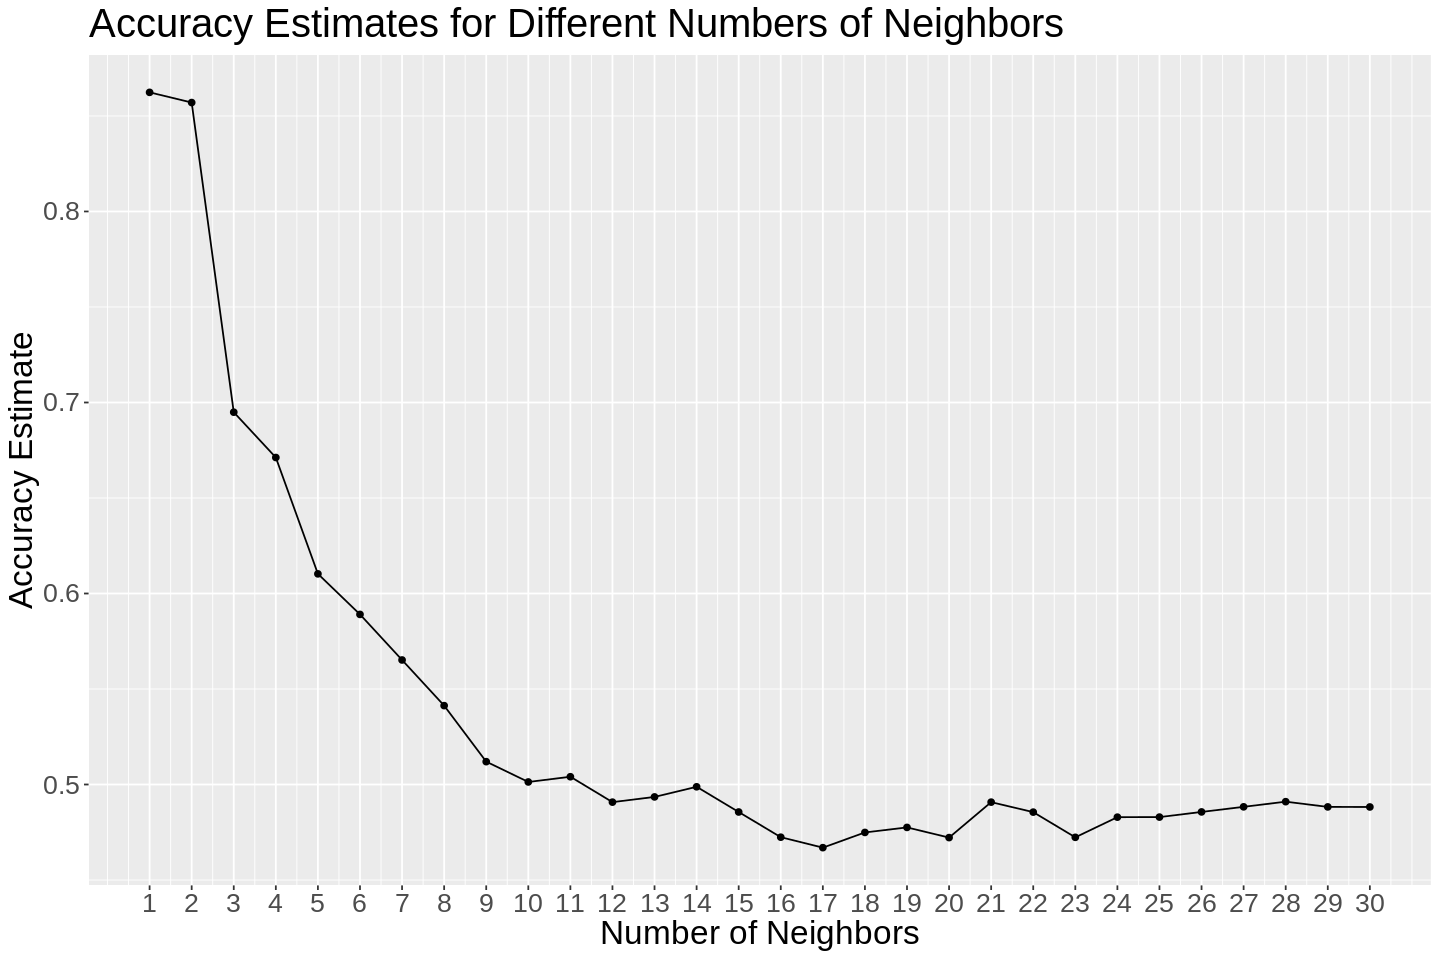

In [61]:
#create line plot with data points for accuracy estimate vs neighbors to find optimal k value
#(looking for high accuracy estimate with high values of accuracy for nearby values of k as well)

options(repr.plot.height = 8, repr.plot.width = 12)
finding_k_plot <- ggplot(weather_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)

paste("Figure 1 - Accuracy Estimates for Different Number of Neighbors")
finding_k_plot
paste("Caption - This figure visualizes the data from the table above so that we can make sure we pick
an optimal value of k in which nearby values also have relatively good accuracy values.")

In [24]:
#retrain our model with the newfound value of k and fit it to our training data

#since k = 1 has the highest accuracy, we will use that in our new model

weather_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

weather_fit_final <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_model) %>%
    fit(data = upsampled_weather)

In [62]:
#we can now use our fitted model to predict the weather for our testing data set

weather_predictions <- predict(weather_fit_final, weather_test) %>%
    bind_cols(weather_test) %>%
    select(.pred_class, Weather)

paste("Table 4.1 - Predicted vs True Weather Class")
weather_predictions
paste("Caption - This table showcases the predicted weather classification made by
our model on the testing data next  to the true weather classification.")

[1] "Table 4.1 - Predicted vs True Weather Class"

.pred_class,Weather
<fct>,<fct>
Mostly Cloudy,Mostly Cloudy
Mostly Cloudy,Mostly Cloudy
Cloudy,Cloudy
Mainly Clear,Mainly Clear
Rain Showers,Rain Showers
⋮,⋮
Mainly Clear,Mainly Clear
Cloudy,Cloudy
Mostly Cloudy,Mostly Cloudy


[1] "Caption - This table showcases the predicted weather classification made by\nour model on the testing data next  to the true weather classification."

In [63]:
#we can use the metrics function to see how accurate our model was at predicting weather values 
#on the testing dataset

weather_metrics <- weather_predictions %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

paste("Table 4.2 - Accuracy of Model on Test Data")
weather_metrics
paste("Caption - This table shows us the overall accuracy of our model when predicting all 
of the observations in our testing data set using the model that we created.")

[1] "Table 4.2 - Accuracy of Model on Test Data"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8943089


[1] "Caption - This table shows us the overall accuracy of our model when predicting all \nof the observations in our testing data set using the model that we created."

In [65]:
#we can also use a confusion matrix to see a table of predicted and correct labels

confusion <- weather_predictions %>%
    conf_mat(truth = Weather, estimate = .pred_class)

paste("Figure 2 - Confusion Matrix Showing the Predicted and Correct Classes of Weather")
confusion
paste("Caption - The confusion matrix allows us to see where our model guessed correctly and incorrectly,
which class it guessed when it was incorrect, and how many times it guessed each class.")

[1] "Figure 2 - Confusion Matrix Showing the Predicted and Correct Classes of Weather"

               Truth
Prediction      Mostly Cloudy Cloudy Rain Showers Rain Mainly Clear
  Mostly Cloudy            36      2            1    5            0
  Cloudy                    0     23            0    0            0
  Rain Showers              0      0           12    0            0
  Rain                      0      3            0   26            0
  Mainly Clear              0      0            2    0           13

[1] "Caption - The confusion matrix allows us to see where our model guessed correctly and incorrectly,\nwhich class it guessed when it was incorrect, and how many times it guessed each class."

In [37]:
set.seed(2022)
proportions
weather_test_mostly_cloudy <- weather_test %>% filter(Weather == "Mostly Cloudy") 

predict(weather_fit_final, weather_test_mostly_cloudy) %>%
    bind_cols(weather_test_mostly_cloudy) %>%
    select(.pred_class, Weather) %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

nrow(weather_test_mostly_cloudy)

Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,113,29.97347
Cloudy,84,22.28117
Rain Showers,30,7.95756
Rain,103,27.32095
Mainly Clear,47,12.46684


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,1


[1] 36

## Discussion

## References


Government of Canada. (2022, May 25). *Historical Data—Climate—Environment and Climate Change.* Canada.ca. https://climate.weather.gc.ca/historical_data/search_historic_data_e.html

Martinez, F., et al. (2021, Apr 5). *Time Series Forecasting with KNN in R: the tsfknn Package.* CRAN. https://cran.r-project.org/web/packages/tsfknn/vignettes/tsfknn.html

Zhang, J. (2020, Jan 31). *Dynamic Time Warping.* Medium. https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

